# машинный перевод

Задача машинного перевода - задача из разряда seq2seq. В ней на основе одной последовательности (например, текста) требуется сгенерировать другую последовательность (текст на другом языке).

В случае с машинным переводом модель выучивает функцию $p(y|x, \theta)$ и задача принимает вид:

$$y^* = \underset{y}{\mathrm{argmax}} p(y|x, \theta)$$

Качество машинного перевода будем оценивать с помощью метрики BLEU

Значение $BLEU \in [0, 1]$, чем больше, тем лучше приближается корпус текстов нашей моделью.

# Модель. Encoder-decoder на RNN

сначала реализуем модель перевода с русского языка на английский в стиле, представленном ниже и обучим её. (пока без attention)

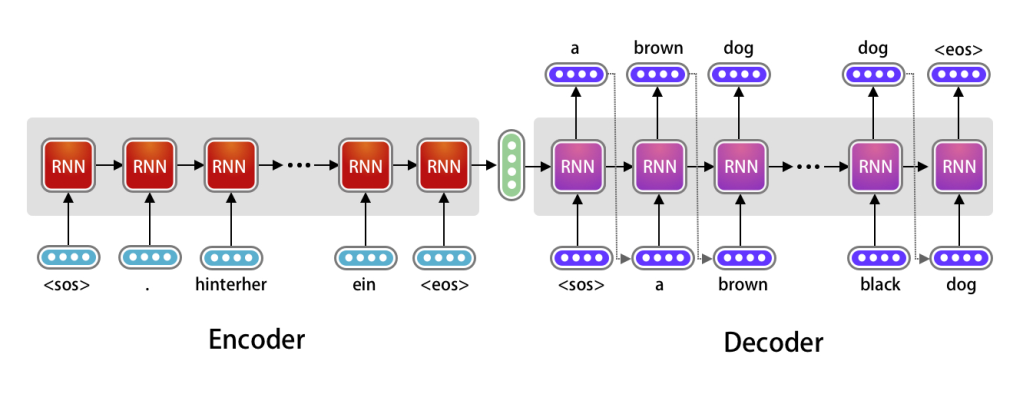

In [1]:
from PIL import Image
im = Image.open("ed_base.jpg")
im

В качестве токенов будем использовать слова русского и английского языка + пробел + знаки препинания + цифры

In [ ]:
# modules import
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import sys
import numpy as np
import torch
from tqdm.notebook import tqdm
from torch.optim import Adam
import os
import subprocess

from matplotlib import pyplot as plt
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import shutil
import random
import itertools
from datasets import load_metric

bleu_metric = load_metric("bleu")

In [2]:
VALIDATION_PROP = 0.1
RANDOM_STATE = 79

dir = 'data/'
X_TRAIN_PATH = 'en_train.txt'
Y_TRAIN_PATH = 'ru_train.txt'
X_VALID_PATH = 'en_valid.txt'
Y_VALID_PATH = 'ru_valid.txt'
TRAIN = False

HIDDEN_SIZE = 256
LSTM_LAYERS = 3
INPUT_SIZE = 256
BATCH_SIZE = 32
IS_BIDIRECTIONAL_LAYERS = False
CNT_CLASSES = None

SOS_TOKEN = "<SOS>" # start of sentence token
EOS_TOKEN = "<EOS>" # end of sentence token
UNK_TOKEN = "<UNK>" # unknown token
PAD_TOKEN = "<PAD>" # padding token
PAD_IND = 3
SOS_IND = 0
EOS_IND = 1
EPOCHS = 10
MODEL_NAME = 'lstm_basic_model'
SCHEDULER_LAMBDA_PARAM = 0.95
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_FOLDER_PATH = MODEL_NAME
LR = 0.0004
CLIP = 1
TEACHER_FORCING_RATIO = 0
FULL_DATA_PATH = 'data.txt'

WRITE_CNT_STEPS = 100
SCHEDULER_CNT_STEPS = 300
GREEDY_DECODING_LABEL = 'greedy'
BEAM_SEARCH_DECODING_LABEL = 'beam_search'

NEC_TOKENS_LEN = 25  # tokens max count for inference
MAX_TEXT_LEN = 25 # max words count for text
BEAM_WIDTH = 3

signs = '.,?!:; '
numbers = ''.join([str(i) for i in range(10)])
RUSSIAN_LETTERS_AND_SIGNS = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя' + signs + numbers
ENGLISH_LETTERS_AND_SIGNS = ''.join([chr(i) for i in range(ord('a'), ord('z') + 1)]) + signs + numbers
print(RUSSIAN_LETTERS_AND_SIGNS, ENGLISH_LETTERS_AND_SIGNS)

абвгдеёжзийклмнопрстуфхцчшщъыьэюя.,?!:; 0123456789 abcdefghijklmnopqrstuvwxyz.,?!:; 0123456789


**разбиваем данные на тренировочную/валидационную части**

In [3]:
from prepare_data import split_data

In [4]:
split_data(dir, FULL_DATA_PATH, X_TRAIN_PATH, Y_TRAIN_PATH, X_VALID_PATH, Y_VALID_PATH, 
           MAX_TEXT_LEN, VALIDATION_PROP, RANDOM_STATE)

Будем использовать в качестве токенов слова (английского и русского алфавитов), цифры и некоторые знаки препинания.

In [6]:
# create model folder
if not os.path.exists(MODEL_FOLDER_PATH):
  os.makedirs(MODEL_FOLDER_PATH)

датасеты и даталоадеры

In [4]:
from prepare_data import TranslationDataset

In [5]:
# create train and val dataset (val tokenizers are the same as in train)
train_dataset = TranslationDataset(
    x_seq_path=dir + X_TRAIN_PATH,
    y_seq_path=dir + Y_TRAIN_PATH,
    is_train=True,
    x_seq_len=NEC_TOKENS_LEN,
    y_seq_len=NEC_TOKENS_LEN)

val_dataset = TranslationDataset(
    x_seq_path=dir + X_VALID_PATH,
    x_tokenizer=train_dataset.x_tokenizer,
    y_seq_path=dir + Y_VALID_PATH,
    x_seq_len=NEC_TOKENS_LEN,
    y_seq_len=NEC_TOKENS_LEN,
    y_tokenizer=train_dataset.y_tokenizer,
    is_train=True
)

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [6]:
# cnt classes if it is neccessary
if CNT_CLASSES is None:
  CNT_CLASSES = train_dataset.cnt_y_tokens()

In [7]:
print(train_dataset.cnt_x_tokens(), train_dataset.cnt_y_tokens())

25058 34165


In [2]:
from models import EncoderDecoderModel, model_size

In [ ]:
# define model and move it to device
model = EncoderDecoderModel(
    input_voc_size=train_dataset.cnt_x_tokens(),
    device=device,
    cnt_classes=train_dataset.cnt_y_tokens())
model = model.to(device)

**параметры модели**

In [65]:
model_size(model)

model size: 103 MB


In [66]:
model(torch.randint(train_dataset.cnt_x_tokens(), (32, 25)).to(device), None).shape

torch.Size([32, 25, 1, 34165])

Определим функцию потерь для задачи "классификации", оптимизатор, scheduler. И обучим модель

In [15]:
from train import train

In [12]:
# use CrossEntropyLoss because the task is something like classification
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_dataset.x_tokenizer.pad_idx)
# define optimizer
optimizer = Adam(model.parameters(), lr=LR)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# define writer for using tensorboard
#writer = SummaryWriter('runs/{}'.format(MODEL_NAME))

# define scheduler (policy of lr change)
lambda_scheduler = lambda x: SCHEDULER_LAMBDA_PARAM ** x
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

In [13]:
TRAIN = True

In [74]:
if TRAIN:
  base_enc_dec_model = train(
      model=model,
      model_name=MODEL_NAME,
      train_dataloader=train_dataloader,
      optimizer=optimizer,
      scheduler=scheduler,
      loss_fn=loss_fn,
      #writer=writer,
      clip=CLIP,
      teacher_forcing_ratio=TEACHER_FORCING_RATIO,
      epochs=EPOCHS
  )

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> this 3bedroom villa will provide you with a tv , air conditioning and a balcony . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств с с и и и и и и и . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  эта вилла оснащена кондиционерами и располагает 3 спальнями , телевизором и балконом . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 5.569924750328064
i = 199
X:  <SOS> the comforsuite is well communicated with local services such as restaurants , bars and public transport . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеля в в в в , , , , , , и . . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  рядом с апартотелем находятся рестораны , бары и остановки общественного транспорта . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 5.547113733291626
i = 299
X:  <SOS> secure , private parking and garages are available on sit

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в могут гостей открывается и и и и и . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 5.170022574023924
EPOCH 2:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> enjoying quiet , green surroundings , design hotel dhotel is a great base for exploring russias capital . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  отель дом находится в в в в в в в в в в в в . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  окруженная зеленью гостиница дизайн отель дотель отлично подходит для посещения столицы россии . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.911452951431275
i = 199
X:  <SOS> all units have a kitchen equipped with a dishwasher and oven . a microwave and kettle are also available . <EOS> <PAD> <PAD> <PAD>
Answer:  в числе удобств кухня кухня , , , , , , , , и . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  кухня оборудована духовкой , посудомоечной машиной , микроволновой печью и чайником . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.90443480014801
i = 299
X:  <SOS> opra bastille is 700 metres from the hotel and t

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в распоряжении гостей удобств лаундж , и и и . . . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.896729942681133
EPOCH 3:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> santa maria maggiore is 3.3 km from 4family colosseo , while sapienza university of rome is 3.3 km away . <EOS> <PAD> <PAD> <PAD>
Answer:  расстояние от находится находится в в км км от , , , в в км км км . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  апартаменты 4family colosseo находятся в 3,3 км от церкви сантамариямаджоре и римского университета сапиенца . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.501926031112671
i = 199
X:  <SOS> daily breakfast is served in buffet style at hotel murat . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  каждое утро в завтрак завтрак завтрак завтрак завтрак . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  ежедневно в отеле murat сервируется завтрак шведский стол . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.519292347431183
i = 299
X: 

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в распоряжении гостей в лаундж , и и и . . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.773292386013528
EPOCH 4:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> centre of zakopane is located 5 km away from willa krzesanica . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  расстояние до находится в в км от от . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  центр закопане находится в 5 км от виллы krzesanica . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.286450443267822
i = 199
X:  <SOS> tarragona is 37 km from cubelles sea side , while castelldefels is 27 km from the property . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  расстояние находится находится в км км от км , , а а в км км км . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  город таррагона находится в 37 км от апартаментов cubelles sea side , а город кастельдефельс в 27 км . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.227426111698151
i = 299
X:  <SOS> the accommodation is air conditioned and is equipped with a 

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств в лаундж для и для для для . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.699793297311534
EPOCH 5:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> guests can also enjoy inroom cable tv . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств в телевизор и и каналами . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  гости также могут посмотреть программы кабельного телевидения . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.0615962266922
i = 199
X:  <SOS> free private parking is possible . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  на территории обустроена бесплатная парковка . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  рядом с отелем находится бесплатная парковка . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств в помещения для и и лаундж . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.671790340672368
EPOCH 6:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> art hotel managua is a property offering its guests free breakfast with the rate . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле отеля отеля бесплатный бесплатный бесплатный . . . . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  к услугам гостей отеля art managua бесплатный завтрак . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.851477084159851
i = 199
X:  <SOS> the guest house also proposes activities including hikes , donkey rides and it can organise tours and transfers . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в территории , можно и , , , , , , , , , , и и и . . . . . . .
Target:  кроме того , гости могут совершить пешие прогулки и покататься на ослах . для гостей также организуют туры и трансферы . <EOS> <PAD> <PAD> <PAD>
train losses = 3.831917767524719
i = 299
X:  <SOS> featuring free outdoor pool and airconditioned accommodation , vill

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе , в для для для и и и . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.670426982036536
EPOCH 7:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> christopher st sheridan square underground station is 2 minutes walk . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  станция до метро находится находится в в в минутах ходьбы ходьбы . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  станция метро christopher st sheridan square расположена в 2 минутах ходьбы . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.646293981075287
i = 199
X:  <SOS> phnom penh international airport is 18 km from the guesthouse . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  расстояние до аэропорта аэропорта в составляет км км . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  расстояние до международного аэропорта пномпеня составляет 18 км . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств в для для для для и и . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.685461108235345
EPOCH 8:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> views of downtown spokane are included . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  из окон открывается вид вид на . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  из окон открывается вид на центр города спокан . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.4934197640419007
i = 199
X:  <SOS> featuring free wifi , it offers a gym , sauna and a hot tub . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  к услугам гостей бесплатный wifi , , , , , и сауна . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  к услугам гостей бесплатный wifi , тренажерный зал , сауна и гидромассажная ванна . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.5061272192001343
i = 299
X:  <SOS> dubrovnik airport is 16 km away . <

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств в помещения для для и и лаундж . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.7168398387190225
EPOCH 9:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> an array of activities can be enjoyed on site or in the surroundings , including cycling . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  на территории и в окрестностях можно заняться заняться видами отдыха отдыха отдыха отдыха числе числе . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  на территории и в округе можно заняться различными активными видами отдыха , в том числе велоспортом . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.352679758071899
i = 199
X:  <SOS> quinta do regato is located in moreiras grandes , 15 km from torres novas . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  отель дом отпуска расположен находится в в , , , в км от от города . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  ферма quinta do regato находится в деревне морейраш грандеш , в 15 км от города торришноваш . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.367613904476166
i = 299
X:  <SOS> many other beach

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе удобств в помещения для совещаний и и лаундж . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.765315385832303
EPOCH 10:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> apartments novak is situated 38 km from pula airport . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  апартаменты центр находится в в км от аэропорта . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  апартаменты novak расположены в 38 км от аэропорта пулы . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.2348230695724487
i = 199
X:  <SOS> albergo la corte albertina is 9 km from the a33 motorway and a 20minute drive from alba . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  отель отель inn находится находится находится в в км от от города и и в минутах езды езды от . . <EOS> <EOS> <EOS> <EOS>
Target:  отель albergo la corte albertina находится в 9 км от автомагистрали a33 и в 20 минутах езды от города альбы . <EOS> <PAD> <PAD> <PAD>
train losses = 3.213384246826172
i = 299
X:  <SOS> at riad dar vima guests will find 

0it [00:00, ?it/s]

X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе гостей в для для для для и лаундж . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  помимо этого , в распоряжении гостей общий лаундж и помещения для проведения конференций . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
VAL LOSS = 4.8097855561021445


# teacher forcing

Полученные результаты по лоссу и визуально выглядят не очень убедительно. 

Попробуем подсказывать модели верный токен на каждом шаге с какой-то вероятностью, чтобы направлять обучение в нужную нам сторону.

In [13]:
MODEL_NAME = 'lstm_teacher_forcing_model'
TEACHER_FORCING_RATIO = 0.5

if not os.path.exists(MODEL_NAME):
  os.makedirs(MODEL_NAME)

# define model and move it to device
model = EncoderDecoderModel(
    input_voc_size=train_dataset.cnt_x_tokens(),
    device=device,
    cnt_classes=train_dataset.cnt_y_tokens())
model = model.to(device)

# writer
#writer = SummaryWriter('runs/{}'.format(MODEL_NAME))

# redefine optimizer
optimizer = Adam(model.parameters(), lr=LR)

In [16]:
train(model=model, model_name=MODEL_NAME, train_dataloader=train_dataloader, val_dataloader=val_dataloader,
      optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, #writer=writer,
      clip=CLIP, teacher_forcing_ratio=TEACHER_FORCING_RATIO, epochs=EPOCHS,  timestamp=timestamp, 
      cnt_classes=CNT_CLASSES
)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> for guests comfort , it boasts a 24hour front desk and free wifi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в в в в в в в и и . . . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  к услугам гостей номера с собственной кухней , круглосуточная стойка регистрации и бесплатный wifi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 7.260288143157959
i = 199
X:  <SOS> a restaurant is available . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в в в . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  к вашим услугам также ресторан . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 6.237590732574463
i = 299
X:  <SOS> hotel offers a free kids club for children above

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  на территории отеля аэропорта бесплатный завтрак . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в услугам гостей вид и и и и и и и . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the property include mee

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> a continental breakfast is served each morning at villa chems hamra . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в ресторане в завтрак завтрак в завтрак завтрак . <EOS> . <EOS> . . . . . <EOS> <EOS> . . . . . <EOS>
Target:  каждое утро гостям виллы chems hamra подают континентальный завтрак . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.948592505455017
i = 199
X:  <SOS> the apartment is spacious and features a tv with cable channels , a bath with a bathroom and a shower , as well as
Answer:  в номера удобств телевизор , плоским , и ванная с ванной комната и и и и душем . <EOS> . . <EOS> . <EOS> .
Target:  просторные апартаменты оснащены телевизором с кабельными каналами , а также располагают кухней с посудомоечной машиной и ванной комнатой с ванной и душем . <EOS> <PAD>
train losses = 4.86528434753418
i = 299
X:  <SOS> in the evening , you can return to your spacious apa

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату за дополнительную плату отдо трансфер отдо аэропорта . <EOS> . <EOS> <EOS> . <EOS> . <EOS> . <EOS> . <EOS> . <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в могут работает воспользоваться и и и в дополнительную и и в дополнительную . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the property include m

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> ado international bus station is 1 km from hm playa del carmen , while playa del carmen maritime terminal is 1.2 km from the
Answer:  расстояние от отеля находится в в км км от города и в а в и в в км км от км км от отеля .
Target:  международный автобусный вокзал ado находится в 1 км от отеля hm playa del carmen , а морской терминал плайяделькармен в 1,2 км . <EOS> <PAD>
train losses = 4.25722733259201
i = 199
X:  <SOS> this familyrun hotel is located in barsinghausen , surrounded by weserbergland countryside . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  отель дом расположен расположен расположен в городе расположен , в . . . городе . . <EOS> . . <EOS> . <EOS> <EOS> . <EOS>
Target:  семейный отель zum grnen jger расположен посреди загородной местности холмистого региона везербергланд в городе барзингхаузене . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.19522780418396
i = 299
X:  <SOS> it features a massage parl

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . аэропорта трансфер . <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> .
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле плату предоставляется услуги трансфер . <EOS> . <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> the best western hotel braunschweig offers rooms featuring cable tv . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле гостей отеля отеля отеля inn и и и каналами . <EOS> . <EOS> <EOS> . <EOS> . . . <EOS> . . .
Target:  в распоряжении гостей отеля best western braunschweig номера с кабельным телевидением . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.7344269704818727
i = 199
X:  <SOS> the guest house is located in a quiet area of the ancient city of porec , with its historical centre just 2.5 km from
Answer:  отель дом расположен в центре города , в в , в в в , в в 5 км от <EOS> . . <EOS> км км
Target:  гостевой дом расположен в тихом районе древнего города пореча . исторический центр города находится всего в 2,5 км . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.824636719226837
i = 299
X:  <SOS> the many restaurants , bars , and shops of istiklal street are just a 5m

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  по запросу организуется трансфер отдо аэропорта трансфер отдо аэропорта . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле работает услуги прачечной , а также воспользоваться услугами велосипедов . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> there is a 24hour front desk at the property . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  стойка регистрации работает круглосуточно . <EOS> <EOS> <EOS> регистрации . . . <EOS> <EOS> регистрации . . . . . . <EOS> <EOS> . .
Target:  стойка регистрации работает круглосуточно . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.4564937281608583
i = 199
X:  <SOS> it provides free private parking . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  к услугам гостей бесплатная и бесплатная частная парковка . <EOS> . <EOS> <EOS> . . <EOS> . . . . <EOS> . . . <EOS>
Target:  к услугам гостей терраса и бесплатная частная парковка на территории . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.5721378827095034
i = 299
X:  <SOS> th

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату организуется трансфер отдо аэропорта . <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS> . <EOS> <EOS> <EOS> . <EOS> . <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле работает бесплатный трансфер и трансфер отдо аэропорта . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at th

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> there is also a kitchen , equipped with an oven , microwave and toaster . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  кухня оснащена духовкой , микроволновой печью и холодильником . <EOS> <EOS> <EOS> . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> . <EOS> .
Target:  кухня оснащена духовкой , микроволновой печью и тостером . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.256342329978943
i = 199
X:  <SOS> outside there is a seating area with wooden tables and a small garden . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в апартаментах апартаментах , гостиной с с гостиной и с мебелью . . <EOS> . <EOS> . <EOS> . <EOS> . . . <EOS> .
Target:  на открытом воздухе оборудована гостиная зона с деревянными столами и небольшим садом . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.2981379294395445
i = 299
X:  <SOS> ilhus city ce

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату организуется трансфер отдо аэропорта трансфер отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле работает бесплатный wifi и и прокат велосипедов . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other f

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> a bus with connections to the airport also stops within 100 metres . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в от метрах от автобус , до до до . <EOS> . <EOS> <EOS> <EOS> . . . <EOS> <EOS> . <EOS> <EOS> км .
Target:  в 100 метрах останавливается автобус , следующий до аэропорта . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.074541494846344
i = 199
X:  <SOS> guest can relax on the outdoor dining patio . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  гости могут отдохнуть отдохнуть на террасе на террасе . <EOS> . . <EOS> воздухе . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  гости отеля могут провести время во внутреннем дворе с обеденной зоной на открытом воздухе . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.144833257198334
i = 299
X:  <SOS> free wifi access is availa

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату организуется трансфер отдо аэропорта . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  гости могут воспользоваться услугами на территории и в в в в в . . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the 

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> the staff at the 24hour front desk can assist with luggage storage service . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  на круглосуточной стойке регистрации предоставляются услуги хранения багажа . <EOS> . регистрации . . . <EOS> . <EOS> <EOS> . . <EOS> <EOS> <EOS> <EOS>
Target:  на круглосуточной стойке регистрации работает камера хранения багажа . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.9239522337913515
i = 199
X:  <SOS> a free airport shuttle is offered at moncton fairfield inn suites . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле типа постель и завтрак организуют воспользоваться трансфер трансфер . <EOS> . <EOS> <EOS> . <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS>
Target:  гости отеля moncton fairfield inn suites могут воспользоваться бесплатным трансфером до аэропорта . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату организуется трансфер отдо аэропорта . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  гости могут воспользоваться услугами услугами и и и и по запросу , а в от от от . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the property include meet

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> the apartment is airconditioned and comes with a furnished patio . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  апартаменты апартаментах апартаментах апартаментах есть кондиционер и гостиная зона патио . . <EOS> . <EOS> . . <EOS> <EOS> . <EOS> <EOS> <EOS> . <EOS>
Target:  в апартаментах в ваше распоряжении кондиционер и собственный внутренний меблированный двор . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.7495811080932615
i = 199
X:  <SOS> sunshine hotel fourseasons is located within suzhou industrial park , about 6 km from suzhou yuanqu railway station . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  отель отель находится в городе км , в 5 км от центра от центра вокзала . <EOS> <EOS> км . . <EOS> <EOS> . .
Target:  отель sunshine fourseasons находится в промышленном парке сучжоу , в 6 км отжелезнодорожного вокзала сучжоу . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train l

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату организуется трансфер отдо аэропорта . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле работает работает услуги и и организуют трансфер до аэропорта , . в от отеля . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at th

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> royal marina apartments is located in a complex in the small town of didim and it is only 1 km from the beach .
Answer:  апартаменты la la расположен в городе центре города , , в в 2 км от пляжа . <EOS> <EOS> <EOS> <EOS> км . <EOS> <EOS>
Target:  комплекс апартаментов royal marina расположен в небольшом городе дидим , всего в 1 км от пляжа . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.60947301864624
i = 199
X:  <SOS> kackar restaurant serves a range of international cuisine freshly prepared . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в ресторане отеля подают блюда блюда блюда кухни . <EOS> <EOS> <EOS> . . . . . . <EOS> <EOS> <EOS> . . <EOS> .
Target:  в ресторане kackar подают свежеприготовленные блюда интернациональной кухни . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.596047058105469
i = 299
X:  <SOS> certain units feature views of t

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  трансфер отдо аэропорта предоставляется трансфер отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  для гостей отеля работает бизнесцентр и и на территории отеля , который можно в в . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered

EncoderDecoderModel(
  (encoder_embed): Embedding(25058, 256)
  (encoder_lstm_layer): LSTM(256, 256, num_layers=3, batch_first=True)
  (decoder_embed): Embedding(34165, 256)
  (decoder_lstm_layer): LSTM(256, 256, num_layers=3, batch_first=True)
  (decoder_linear): Linear(in_features=256, out_features=34165, bias=True)
)

Видим, что лосс на тренировке в данном случае за то же количество эпох достиг сильно меньшего значения.

На валидации значение функции потерь в новом методе тренировки оказалась даже больше. (но это не показатель, ведь bleu растёт)

Также качество перевода возросло. Как на валидации, так и на тренировке качество перевода значительно выше, чем было до этого.

**-> teacher forcing - хороший подход**

# Attention

In [27]:
from models import EncoderDecoderAttentionModel

In [28]:
MODEL_NAME = 'lstm_attention_model'
TEACHER_FORCING_RATIO = 0.5
TRAIN = True

if not os.path.exists(MODEL_NAME):
  os.makedirs(MODEL_NAME)

# define model and move it to device
model = EncoderDecoderAttentionModel(
    input_voc_size=train_dataset.cnt_x_tokens(),
    device=device,
    cnt_classes=train_dataset.cnt_y_tokens())
model = model.to(device)

# writer
#writer = SummaryWriter('runs/{}'.format(MODEL_NAME))

# redefine optimizer
optimizer = Adam(model.parameters(), lr=LR)

if TRAIN:
  attention_enc_dec_model = train(model=model, model_name=MODEL_NAME, train_dataloader=train_dataloader, val_dataloader=val_dataloader,
                                  optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, #writer=writer,
                                  clip=CLIP, teacher_forcing_ratio=TEACHER_FORCING_RATIO, epochs=EPOCHS,  timestamp=timestamp, 
                                  cnt_classes=CNT_CLASSES
                            )

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1:


train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> guests can play chess , enjoy a foot massage or appreciate tea within the hotel . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в в в в в в и . . . . . . . . . . . . . . . . . .
Target:  на территории отеля гости могут поиграть в шахматы , заказать приятный массаж ступней и выпить чай . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 7.217166028022766
i = 199
X:  <SOS> the charming main town of folegandros island is 3 km away and features many bars and traditional taverns . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в в в в в в в , , , , . . . . . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  очаровательный главный город острова фолегандрос находится в 3 км . здесь работает множество баров и традиционных таверн . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 6.219419727325439
i = 299
X:  <SOS> you will find a 24hour front desk at the property . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
An

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  на территории отеля аэропорта аэропорта аэропорта аэропорта . . . . . . <EOS> . <EOS> . <EOS> . <EOS> . <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле отеля отеля завтрак в , и и и и и . . <EOS> . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the property include meeting facilities and a shared lounge . 

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> the wellappointed rooms at yang ming shan tien lai resort spa come with modern interiors . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в номера отеля в в в в в в и и и и . . <EOS> . . . . . . <EOS> . <EOS>
Target:  хорошо оборудованные номера курортного спаотеля yang ming shan tien lai оформлены в современном стиле . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 5.083686175346375
i = 199
X:  <SOS> the hotel offers a sauna , an outdoor pool and a free shuttle to the beach . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в услугам гостей гостей , , и и и и и и и . . . . . . <EOS> <EOS> . . <EOS> <EOS>
Target:  в отеле к услугам гостей сауна и открытый бассейн . кроме того , гости могут бесплатно воспользоваться услугами трансфера до пляжа . <EOS> <PAD> <PAD>
train losses = 5.0123542261123655
i = 299
X:  <SOS> it features a restaurant and bar , an outdoor pool , and free wifi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату трансфер трансфер аэропорта аэропорта трансфер аэропорта аэропорта аэропорта . . <EOS> . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  гости могут отдохнуть в могут и в и и в в и . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the propert

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> featuring modern thai dcor , guest rooms at the hotel have attached bathrooms with hot shower facilities . each room is equipped with a
Answer:  в номера отеля отеля оформлены в в услугам , с , собственная ванная с ванная с душем и <EOS> . <EOS> . <EOS> . .
Target:  номера оформлены в современном тайском стиле и располагают ванной комнатой с горячим душем , телевизором и минибаром . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.35796213388443
i = 199
X:  <SOS> the stylish , airconditioned dormitory room are decorated with wall paintings and include individual lockers . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в номера номера и в оформлены , и и и и и и и . <EOS> . <EOS> <EOS> <EOS> . . <EOS> . .
Target:  стильные общие номера украшены настенной живописью . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 4.329875955581665
i = 299
X:  <SOS> every room includes a tv . c

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . <EOS> аэропорта аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в отеле работает услуги услуги и и напрокат напрокат , а в дополнительную . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facili

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> the classic rooms are fitted with a satellite tv , radio and a panel heater . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  в числе оснащены телевизором , телевизором каналами , спутниковыми и <EOS> . . <EOS> . . . . . <EOS> . . . <EOS> .
Target:  классические номера оснащены телевизором со спутниковыми каналами , радио и панельным обогревателем . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.8551667594909667
i = 199
X:  <SOS> after a restful night of sleep , guests can take advantage of the fitness center or go for a swim in the indoor pool
Answer:  в отеля в в в в в в в . <EOS> в баре или . <EOS> . . <EOS> <EOS> . <EOS> <EOS> . <EOS>
Target:  после спокойного ночного сна гости могут позаниматься в фитнесцентре или поплавать в крытом бассейне . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.852338216304779
i = 299
X:  <SOS> private bathroom comes with free toiletries , bathrobe and a h

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . <EOS> отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  гости могут воспользоваться услуги напрокат велосипедов , а также взять напрокат велосипед . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> a large work desk with ergonomic chair comes as standard , and some rooms offer a relaxing jacuzzi bathtub . <EOS> <PAD> <PAD> <PAD>
Answer:  в некоторых номерах есть номеров балкон , а в комната , а в некоторых номерах есть них гостей балкон . . <EOS> <EOS> . <EOS>
Target:  в стандартное оснащение входит большой рабочий стол с эргономичным стулом , а в некоторых номерах в распоряжении гостей гидромассажная ванна . <EOS> <PAD> <PAD> <PAD>
train losses = 3.560067687034607
i = 199
X:  <SOS> breakfast and starbucks coffee are available each morning at the bistro . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  по утро в отеле сервируется завтрак завтрак . <EOS> . . . <EOS> <EOS> . . <EOS> <EOS> . . <EOS> . <EOS> . <EOS>
Target:  каждое утро в кафе bistro сервируют завтрак и кофе фирмы starbucks . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.5763687324523925
i = 299
X:  <SOS> the balcony op

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . трансфер отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в того , в отеле можно воспользоваться услугами и и и и . <EOS> . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at th

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> all the apartments come with a seating and dining area with a tv . the kitchen is complete with a dishwasher , while the
Answer:  в апартаментах апартаментах есть гостиная гостиная уголок , гостиная зона , кухня с кухня с духовкой машиной и духовкой . комната с душем . <EOS>
Target:  в числе удобств всех апартаментов гостиный уголок , обеденная зона , телевизор , кухня с посудомоечной машиной и собственная ванная комната с душем . <PAD>
train losses = 3.3457995438575745
i = 199
X:  <SOS> gdansk lech walesa airport is 47 km away . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  расстояние до аэропорта аэропорта имени составляет составляет км км . <EOS> <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> км . <EOS> . <EOS> . .
Target:  гданьский аэропорт имени леха валенсы расположен в 47 км . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.3409292674064637
i = 299
X:  <SOS> a

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . <EOS> отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  для гостей для услуги и и , а также также также в в . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities offered at the propert

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> distance from the closest shopping opportunity is 3,8 km , restaurant 7,6 km . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  расстояние до железнодорожного вокзала составляет составляет 2 <EOS> города составляет составляет км км <EOS> <EOS> <EOS> <EOS> <EOS> . <EOS> <EOS> <EOS> . . .
Target:  в 3,8 км работает ближайший магазин . до ресторана 7,6 км . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 3.1377723932266237
i = 199
X:  <SOS> at professional but friendly hotel capitol you will also benefit from free wifi access and free garage parking on site . <EOS> <PAD> <PAD>
Answer:  в отеле удобств отеля отеля бесплатный wifi . на могут воспользоваться бесплатной парковкой и на интернет . <EOS> . <EOS> . <EOS> . . <EOS>
Target:  в гостеприимном отеле capitol работают профессиональные сотрудники . гости могут бесплатно пользоваться беспроводным доступом в интернет и парковкой в гараже на территории отеля .

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . <EOS> аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  на территории отеля можно воспользоваться услугами и и . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> all units are fully equipped , are conditioned and include seating and dining area . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  во всех апартаментах удобств полностью есть полностью оборудованная кухня и и обеденная зона . <EOS> . . <EOS> . . <EOS> <EOS> . . .
Target:  во всех полностью оборудованных апартаментах среди удобств кондиционер , гостиная и обеденная зоны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.9411252665519716
i = 199
X:  <SOS> a sports centre with tennis , football and basketball courts can be reached on foot within 10 minutes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  в 10 минутах ходьбы дойти и гольфа и и , , в в можно дойти за 10 минут . <EOS> <EOS> <EOS> . <EOS> .
Target:  до спортивного комплекса с площадками для игры в теннис , футбол и баскетбол можно дойти за 10 минут . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.9092644381523134
i = 299
X:  <SOS> rooms include a private bathro

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату предоставляется трансфер отдо аэропорта . <EOS> отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  для гостей предоставляются услуги прачечной и а также в том числе отправиться в окрестностям . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> othe

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> guests can enjoy their meals either inside or outside by the pool area . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  гости можно заказать отдохнуть на в или на на . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> . <EOS> . . . <EOS> . .
Target:  блюда могут быть поданы в помещении или на открытом воздухе у бассейна . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.7481374633312226
i = 199
X:  <SOS> guests can enjoy beach access and views from the balcony . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  из балкона открывается вид вид на город . <EOS> <EOS> <EOS> . . . . <EOS> . <EOS> . <EOS> <EOS> <EOS> . <EOS> .
Target:  с балкона открывается прекрасный вид . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.7348136258125306
i = 299
X:  <SOS> located in the centre of pernera resort , lee apartme

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  за дополнительную плату организуется трансфер отдо аэропорта . <EOS> отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  для гостей предоставляются для для для для проведения и и . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities o

train loader: 0it [00:00, ?it/s]

i = 99
X:  <SOS> breakfast is served between 07:00 and 10:00 each morning , in the dining room looking out over the kennet valley . <EOS> <PAD> <PAD>
Answer:  завтрак завтрак утро в в зале , завтрака на на , в на на . . <EOS> <EOS> <EOS> . <EOS> . . . <EOS>
Target:  завтрак каждое утро подают с 07:00 до 10:00 в столовой с видом на долину кеннет . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.6340692722797394
i = 199
X:  <SOS> breakfast is available daily in the dining room . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  завтрак обеденном зале сервируется завтрак завтрак . <EOS> <EOS> <EOS> <EOS> . <EOS> <EOS> . <EOS> . . <EOS> . . . <EOS> . .
Target:  в обеденном зале ежедневно сервируется завтрак . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
train losses = 2.648627667427063
i = 299
X:  <SOS> each modern apartment has a living room with a sofa be

0it [00:00, ?it/s]

X:  <SOS> hotel <UNK> offers a shuttle service to rostovondon airport for an extra fee . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Answer:  трансфер отдо аэропорта предоставляется трансфер отдо аэропорта . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  для гостей отеля <UNK> организуют трансфер до аэропорта ростованадону за дополнительную плату . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> laundry facilities are provided on site and the hotel can arrange overnight camel trips across the sand dunes . <EOS> <PAD> <PAD> <PAD> <PAD>
Answer:  на территории отеля предоставляются для для для для и и и . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Target:  в отеле предоставляются услуги прачечной и организуются ночные поездки на верблюдах через <UNK> дюны . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
X:  <SOS> other facilities off

In [30]:
torch.save(attention_enc_dec_model.state_dict(), 'lstm_attention_model/model_10_epochs.pkl')

**Attention особо не повлиял на обучение нашей модели.**

В целом оно и ожидаемо, начинает приносить пользу, когда количество слов в предложении сильно больше 20, а в нашем случае максимум 25. 

# inference

In [32]:
from nltk.tokenize import word_tokenize

def greedy_translate(sentence, model):    
    for word in word_tokenize(sentence.lower()):
        if not word in train_dataset.x_tokenizer.tokens:
            print('unknown word:', word)
    
    sen2idx = [0] + train_dataset.x_tokenizer.convert_tokens_to_idx(word_tokenize(sentence.lower())) + [1]
    sen2idx = sen2idx + [3] * (NEC_TOKENS_LEN - len(sen2idx))

    model.eval()
    with torch.no_grad():
        outp = model(torch.Tensor(sen2idx).type(torch.long).unsqueeze(dim=0).to(device), None)

    return ' '.join(train_dataset.y_tokenizer.convert_idx_to_tokens(outp.squeeze().argmax(axis=1).cpu().numpy()))

**тестирую перевод для модели, обучавшейся с teacher forcing и без attention**

In [156]:
#предложение из валидационной части датасета
sentence = 'An array of activities is available in the surrounding environs of the Mirabeagle, including canoeing, skiing and fishing.'
greedy_translate(sentence, model)

unknown word: environs
unknown word: mirabeagle


'в окрестностях местности популярны условия для активного отдыха , , , , и и и и и . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>'

In [157]:
#мои предложения
sentence = 'i want to visit this beautiful hotel at the city center'
greedy_translate(sentence, model)

'рядом с отелем проходит рядом с отелем . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>'

In [155]:
sentence = 'do you like this view from the window'
greedy_translate(sentence, model)

'из окон открывается вид на озеро . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>'

**для модели с attention**

In [40]:
sentences = [
    'An array of activities is available in the surrounding environs of the Mirabeagle, including canoeing, skiing and fishing.',
    'i want to visit this beautiful hotel at the city center',
    'do you like this view from the window'
]

for sentence in sentences:
    print(f"sentence: {sentence}")           
    print(f"translation: {greedy_translate(sentence, attention_enc_dec_model)}")
    print('\n')

sentence: An array of activities is available in the surrounding environs of the Mirabeagle, including canoeing, skiing and fishing.
unknown word: environs
unknown word: mirabeagle
translation: в окрестностях популярны пешие походы , пешие походы , включая как пешие прогулки и велосипедные прогулки . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


sentence: i want to visit this beautiful hotel at the city center
translation: отель отель расположен расположен в окружении здании . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


sentence: do you like this view from the window
translation: из окон открывается вид на город . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>




## beam-search

![](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/beam_search.png)

функция, которая будет возвращать состояние енкодера модели

In [21]:
def encode_part(model, x):
    batch_n = x.shape[0]
    length_tensor = (x != PAD_IND).sum(axis=1).cpu() # get seq lens to pack

    # encoder
    x = model.encoder_embed(x)
    x = pack_padded_sequence(x, length_tensor, batch_first=True, enforce_sorted=False)

    _, prev_state = model.encoder_lstm_layer(x)

    # reshape prev_state
    prev_state = (prev_state[0].reshape(model.lstm_layers, batch_n, -1),
                  prev_state[1].reshape(model.lstm_layers, batch_n, -1))

    return prev_state

класс, который будет соответствовать вершине нашего "дерева поиска". На картинке - оранжевый квадратик. В объекте этого класса будет храниться состояние декодера перед получением данного токена, предыдущую вершину (ноду), id токена и длину уже сформированной последовательности.

In [22]:
class BeamSearchNode:
  def __init__(self, prev_state, prev_node, log_prob, token_idx, length):
      self.prev_state = (prev_state[0].squeeze(1), prev_state[1].squeeze(1))
      self.prev_node = prev_node
      self.token_idx = token_idx
      self.log_prob = log_prob
      self.length = length

  def eval(self):
      return self.log_prob

сам процесс:

- функция get_next_nodes будет нам возвращать следующие beam\_width нод (вершин) с наибольшей вероятностью получить последовательность, которую они хранят

- функция beam_search_inference_for_texts_list будет реализовывать остальную часть метода beam\_search для листа текстов

In [19]:
from prepare_data import clean_text

In [25]:
def get_next_nodes(prev_nodes, beam_width):
    # generate beam_width * len(prev_nodes) candidates for next iteration
    cur_nodes = []
    for prev_node in prev_nodes:
        prev_token_emb = model.decoder_embed(
            torch.tensor([prev_node.token_idx]).to(device)
          )

        out, prev_state = model.decoder_lstm_layer(prev_token_emb, prev_node.prev_state)
        decoder_output = torch.nn.functional.softmax(model.decoder_linear(out), dim=1)
        # choose top k tokens of the current decoder iteration for prev_node
        top_probs, indexes = torch.topk(decoder_output, beam_width)

        # create node for each combination prev_node and one of top k variant
        for top_val, token_idx in zip(top_probs.cpu().detach().numpy()[0], 
                                      indexes.cpu().detach().numpy()[0]):
            cur_node = BeamSearchNode(
                prev_state=prev_state,
                prev_node=prev_node,
                log_prob=prev_node.log_prob + np.log(top_val),
                token_idx=token_idx,
                length=prev_node.length + 1)
            cur_nodes.append(cur_node)

    return sorted(cur_nodes, key=lambda x: -x.log_prob)[:beam_width]


def beam_search_inference_for_texts_list(texts_list, model, x_tokenizer, y_tokenizer, beam_width):
    tokenised_text_list = []
    mx_seq_len = 0
    for text in texts_list:
        text = clean_text(text)
        x_text = x_tokenizer.convert_text_to_idx(text)
        tokenised_text_list.append(x_text)
        mx_seq_len = max(mx_seq_len, len(x_text))

    text_variants = []
    for tok_text in tokenised_text_list:
        x_pad_part = [x_tokenizer.pad_idx] * max(0, mx_seq_len - len(tok_text))

        x = torch.tensor([tok_text + x_pad_part]).to(device)
        prev_state = encode_part(model, x)

        # create <sos> tokens for each sentence
        prev_token_idx = torch.tensor([SOS_IND]).to(device)
        # beam_search start
        all_nodes = []
        prev_nodes = []
        end_nodes = []

        # create BeamSearchNode
        node = BeamSearchNode(
            prev_state=prev_state,
            prev_node=None,
            log_prob=0,
            token_idx=SOS_IND,
            length=1)
        all_nodes.append(node)
        prev_nodes.append(node)

        while True:
            cur_nodes = get_next_nodes(prev_nodes, beam_width)

            # collect end_nodes (if the node is <EOS> token and not first node)
            for cur_node in cur_nodes:
                if cur_node.token_idx == EOS_IND and cur_node.prev_node is not None:
                    end_nodes.append(cur_node)
            all_nodes += cur_nodes
            prev_nodes = cur_nodes
            # finish condition
            if len(end_nodes) >= beam_width or len(all_nodes) >= beam_width * NEC_TOKENS_LEN:
                break

        if len(end_nodes) < beam_width:
          end_nodes += cur_nodes[:beam_width - len(end_nodes)]
        most_likelihood_texts = []

        # collect the most probable texts
        for end_node in end_nodes:
            answer = []
            cur_node = end_node
            while cur_node is not None:
                answer.append(cur_node.token_idx)
                cur_node = cur_node.prev_node

            most_likelihood_texts.append(' '.join(y_tokenizer.convert_idx_to_tokens(answer[::-1])))
        text_variants.append(most_likelihood_texts)
    return text_variants


## результат работы Beam-search

In [18]:
example_texts_list = [
    'the horse cannot cross the road because it was tired.'
    'a free transfer service to tillamook airport, 6 miles away, is provided.',
    'all of the private bathrooms are fitted with a bathtub.',
    'cool drinks and cocktails are served at the lounger bar or pool snack bar.',
    'downtown penthouse is airconditioned and offers a large private balcony.',
    'castiello golf club is 5 km from abba playa.'
]

**Для базовой модели с teacher forcing**

In [26]:
beam_search_inference_for_texts_list(texts_list=example_texts_list, model=model, x_tokenizer=train_dataset.x_tokenizer,
                                     y_tokenizer=train_dataset.y_tokenizer, beam_width=10)

[['<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в трансфер км . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в в км . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в трансфер км от <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в в км км . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в в км . км . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в трансфер км от отеля . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в трансфер км . <EOS> . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в трансфер км . <EOS> км . <EOS>',
  '<SOS> для гостей для гостей организуют трансфер до аэропорта км , расположенного в в км км . <EOS> . <EOS>',
  '<SOS>

# Качество перевода оставляет желать лучшего. 

**Но надо сделать скидку на то, что архитектура всё-таки здесь не трансформер, да и размер датасета весьма скромный.**